
GPT-4o Classification Results:
Filename: Brain Tumor MRI Classfication/Testing/no_tumor/image(1).jpg
True Label: no tumor
Predicted Label: unknown
Analysis: This image appears to be a CT scan of the brain, not an MRI. Based on the visual features, there is a noticeable dark area which might be indicative of bleeding or an abnormal space. However, CT is better for identifying such features rather than differentiating tumors.

For diagnosing specific tumors like glioma, meningioma, or pituitary tumors, MRI is generally preferred due to its superior contrast in soft tissues.

Final Classification: Unable to determine from CT scan.
--------------------------------------------------------------------------------
Filename: Brain Tumor MRI Classfication/Testing/no_tumor/image(10).jpg
True Label: no tumor
Predicted Label: no tumor
Analysis: The MRI scan presented shows characteristics typical of a brain scan in axial view. Evaluating the image, the symmetrical structure is apparent, and no sp

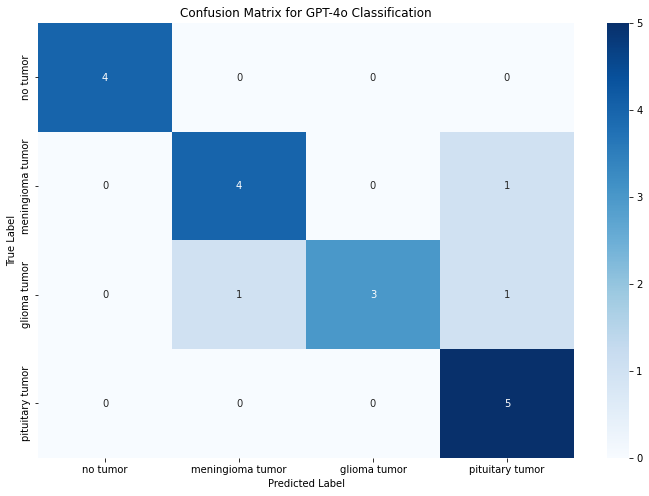

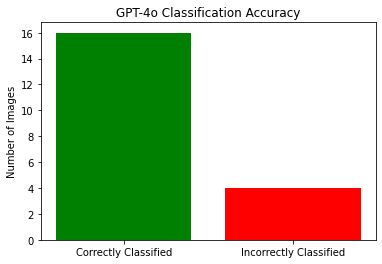

In [13]:
import openai
import base64
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# OpenAI API Key
openai.api_key = "-"

# List of tumor classifications
VALID_CONDITIONS = [
    "glioma tumor", "meningioma tumor", "pituitary tumor", "no tumor"
]

# Define dataset paths
BASE_DIR = "Brain Tumor MRI Classfication"
TEST_DIR = os.path.join(BASE_DIR, "Testing")

def encode_image(image_path):
    """
    Convert an image to base64 encoding for OpenAI Vision API.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"File not found: {image_path}")
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def analyze_mri(image_path):
    """
    Analyzes a brain MRI image with GPT-4o.
    Returns an analysis report including diagnostic insights.
    """
    try:
        image_base64 = encode_image(image_path)
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": (
                    "You are an AI specializing in medical image classification for brain MRI scans. "
                    "Analyze the given MRI scan and determine whether the patient has one of the following conditions: "
                    + ", ".join(VALID_CONDITIONS) + ". "
                    "Provide your analysis first, and at the very end, explicitly state the classification in this format:\n\n"
                    "Final Classification: [condition]\n\n"
                    "Do not provide medical advice or diagnostic opinions—only describe visual features and provide the classification."
                )},
                {"role": "user", "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]}
            ],
            max_tokens=500
        )
        return response.choices[0].message.content  # Return full analysis and classification
    except Exception as e:
        print(f"Error calling GPT-4o API: {e}")
        return None

def extract_final_classification(analysis_report):
    """
    Extracts the final classification label from the last mention of 'Final Classification:' in the GPT-4o response.
    """
    if not analysis_report:
        return "unknown"

    # Convert report to lowercase and split into lines
    lines = analysis_report.strip().split("\n")

    # Iterate in reverse to find "Final Classification:" and extract the condition
    for line in reversed(lines):
        line = line.strip().lower()
        if "final classification:" in line:
            pred_label = line.split("final classification:")[-1].strip()

            # Remove unwanted punctuation but preserve spaces
            pred_label = re.sub(r"[^\w\s]", "", pred_label)

            # Ensure extracted label is valid
            if pred_label in VALID_CONDITIONS:
                return pred_label
            else:
                print(f"Warning: Extracted invalid classification: '{pred_label}'. Check GPT output format.")

    return "unknown"

def evaluate_gpt4o(test_folder):
    """
    Evaluates GPT-4o performance on the brain tumor MRI dataset, processing only the first 3 images per folder.
    """
    results = []

    # Iterate through each class folder (glioma, meningioma, no tumor, pituitary)
    for class_folder in os.listdir(test_folder):
        class_path = os.path.join(test_folder, class_folder)
        
        if not os.path.isdir(class_path):
            continue  # Skip if it's not a folder

        # Process first 5 images in each class folder
        image_files = sorted(os.listdir(class_path))[:5]

        for img_filename in image_files:
            image_path = os.path.join(class_path, img_filename)
            true_label = class_folder.replace("_", " ")  # Match folder names with VALID_CONDITIONS format
            
            if os.path.exists(image_path):
                analysis_report = analyze_mri(image_path)
                pred_label = extract_final_classification(analysis_report)
                
                results.append({
                    "image": image_path,
                    "true_label": true_label,
                    "predicted_label": pred_label,
                    "analysis": analysis_report
                })
            else:
                print(f"Skipping missing image: {image_path}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv("gpt4o_brain_tumor_results.csv", index=False)
    
    # Display results
    print("\nGPT-4o Classification Results:")
    for _, row in results_df.iterrows():
        print(f"Filename: {row['image']}")
        print(f"True Label: {row['true_label']}")
        print(f"Predicted Label: {row['predicted_label']}")
        print(f"Analysis: {row['analysis']}")
        print("-" * 80)
    
    # Classification Report
    print("Classification Report:")
    y_true = results_df['true_label']
    y_pred = results_df['predicted_label']
    
    # Track "unknown" predictions
    unknown_count = (y_pred == "unknown").sum()
    print(f"Number of 'unknown' classifications: {unknown_count}")
    
    # Filter out unknown predictions for valid accuracy calculations
    y_true_filtered = y_true[y_pred != "unknown"]
    y_pred_filtered = y_pred[y_pred != "unknown"]
    
    if not y_true_filtered.empty and not y_pred_filtered.empty:
        print(classification_report(y_true_filtered, y_pred_filtered, labels=y_true_filtered.unique()))
        print("Accuracy:", accuracy_score(y_true_filtered, y_pred_filtered))
    else:
        print("No valid classifications to report.")

    print("\nOverall Accuracy:", accuracy_score(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y_true.unique(), yticklabels=y_true.unique())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for GPT-4o Classification")
    plt.show()

    # Bar Chart of Correct vs Incorrect Classifications
    correct_classifications = (y_true == y_pred).sum()
    incorrect_classifications = len(y_true) - correct_classifications
    
    plt.figure(figsize=(6, 4))
    plt.bar(["Correctly Classified", "Incorrectly Classified"], [correct_classifications, incorrect_classifications], color=['green', 'red'])
    plt.ylabel('Number of Images')
    plt.title('GPT-4o Classification Accuracy')
    plt.show()

# Run evaluation on the Testing dataset
if os.path.exists(TEST_DIR):
    evaluate_gpt4o(TEST_DIR)
else:
    print("Testing dataset folder not found! Ensure you provide a valid path.")